In [2]:
import sys
sys.path.append('../')

import os
import copy
import time
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np
from scipy import sparse
from data import datasets
from data.gene_graphs import GeneManiaGraph,  OntologyGraph
from data.utils import record_result

%load_ext autoreload
%autoreload 2


In [3]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Torrent name: HiSeqV2.gz, Size: 513.04MB
File verified recently. Assumed still correct. Set use_timestamp=False to check again.


In [4]:
# Setup the results dictionary
filename = "../experiments/results/fig-5_ESR1_random.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
#     results = results[results.graph != "random"]
    print("Loaded Checkpointed Results")
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'num_genes', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [25]:
results[results.num_genes< 50]

,auc,acc,gene,model,graph,num_genes,seed,train_size,time_elapsed
1830,0.641847,0.663333,ESR1,GCN_lay1_chan32_emb32_dropout,ontology_el_50_rand,5,0,100,2.716219425201416
1831,0.618727,0.650000,ESR1,GCN_lay1_chan32_emb32_dropout,ontology_el_50_rand,5,1,100,0.8063786029815674
1832,0.607031,0.636667,ESR1,GCN_lay1_chan32_emb32_dropout,ontology_el_50_rand,5,2,100,1.0343143939971924
1833,0.680879,0.710000,ESR1,GCN_lay1_chan32_emb32_dropout,ontology_el_50_rand,10,0,100,0.86942458152771
1834,0.645723,0.666667,ESR1,GCN_lay1_chan32_emb32_dropout,ontology_el_50_rand,10,1,100,1.2852509021759033
...,...,...,...,...,...,...,...,...,...
2067,0.667143,0.690000,ESR1,MLP_lay2_chan512,random_n,5,4,100,0.44524121284484863
2068,0.682443,0.693333,ESR1,MLP_lay2_chan512,random_n,10,3,100,0.4680969715118408
2069,0.655311,0.670000,ESR1,MLP_lay2_chan512,random_n,10,4,100,0.44082140922546387
2070,0.645655,0.663333,ESR1,MLP_lay2_chan512,random_n,30,3,100,0.4529597759246826


In [6]:
gene_graph =  OntologyGraph(neighbors=30, embeddings_name='el')

 loading from cache file/auto/homes/mt675/gene-graph-conv-onto/data/graphs/ontology_el_30.adjlist.gz


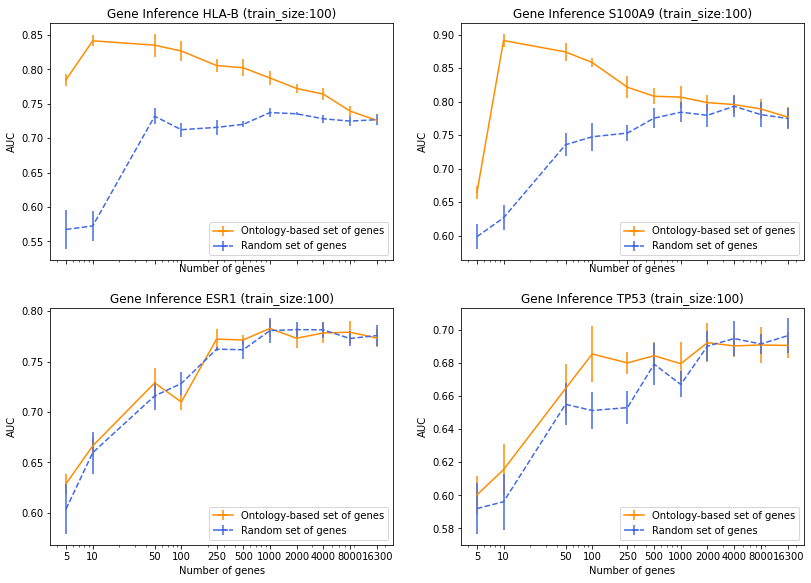

In [12]:
plt.rcParams['figure.figsize'] = (13.5, 9.6)
fig, axs = plt.subplots(2,2, sharex=True, sharey=False)

search_genes = [ "HLA-B", "S100A9", "ESR1", "TP53"] #, "RPL13"] #, "IL5"]
for i, plot_gene in enumerate(search_genes):
    j = int(i/2)
    k = i%2

#     %matplotlib inline
#     plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 100

    subset = results[(results.train_size==plot_train_size) & 
                      (results.gene==plot_gene) & 
                      (results.num_genes > 2) &    
                      (results.num_genes!=30) &      
                      (results.num_genes != 200)  &  
                      (results.num_genes != 300)  &  
                      ((results.graph == "ontology_el_10" ) | (results.graph == "random_n" ))]

    q = subset.groupby(['model', 'graph', 'train_size', 'num_genes'])['auc']

    todo = [x for x in itertools.product( list(subset["graph"].unique()),list(subset["model"].unique()), list(subset["train_size"].unique()))]
#     print(todo)
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, (graph, model, train_size) in enumerate(sorted(todo)):
         if 'agg' not in model and  '512_' not in model and  'GCN' not in model and  'SNLR' not in model:
            if (model, graph, train_size) in q.mean():
                index = list(q.mean()[model, graph,train_size].index)
                mean = q.mean()[model,  graph,train_size]
                stderr = q.std()[model,  graph,train_size]/np.sqrt(q.count()[model, graph,train_size])
                displayname = model.replace("CGN","GCN") +"_"+ graph #+ "_" + str(train_size)
                displayname = displayname.replace("SLR", "SNLR")
                displayname = "Random set of genes" if 'rand' in graph else "Ontology-based set of genes"

                axs[j][k].errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, 
                             ls='-' if 'ontology' in graph else '--', 
                             color= 'darkorange' if 'ontology' in graph else 'royalblue')

    axs[j][k].set_title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    axs[j][k].set_ylabel("AUC")
    axs[j][k].set_xlabel("Number of genes")
    axs[j][k].set_xscale("log")
    axs[j][k].set_xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)

    axs[j][k].legend(loc='lower right');
#     plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5));
#     fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
#     print(fd)
#     if fd > 50:
#         plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
#         c = plt.ylim()
#         plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)

plt.savefig("../experiments/results/figures/sgi.eps", bbox_inches='tight', format='eps')
plt.show()


In [13]:
dataset = datasets.TCGADataset()


Torrent name: HiSeqV2.gz, Size: 513.04MB
File verified recently. Assumed still correct. Set use_timestamp=False to check again.


In [14]:
dataset.df.shape

(10459, 20530)

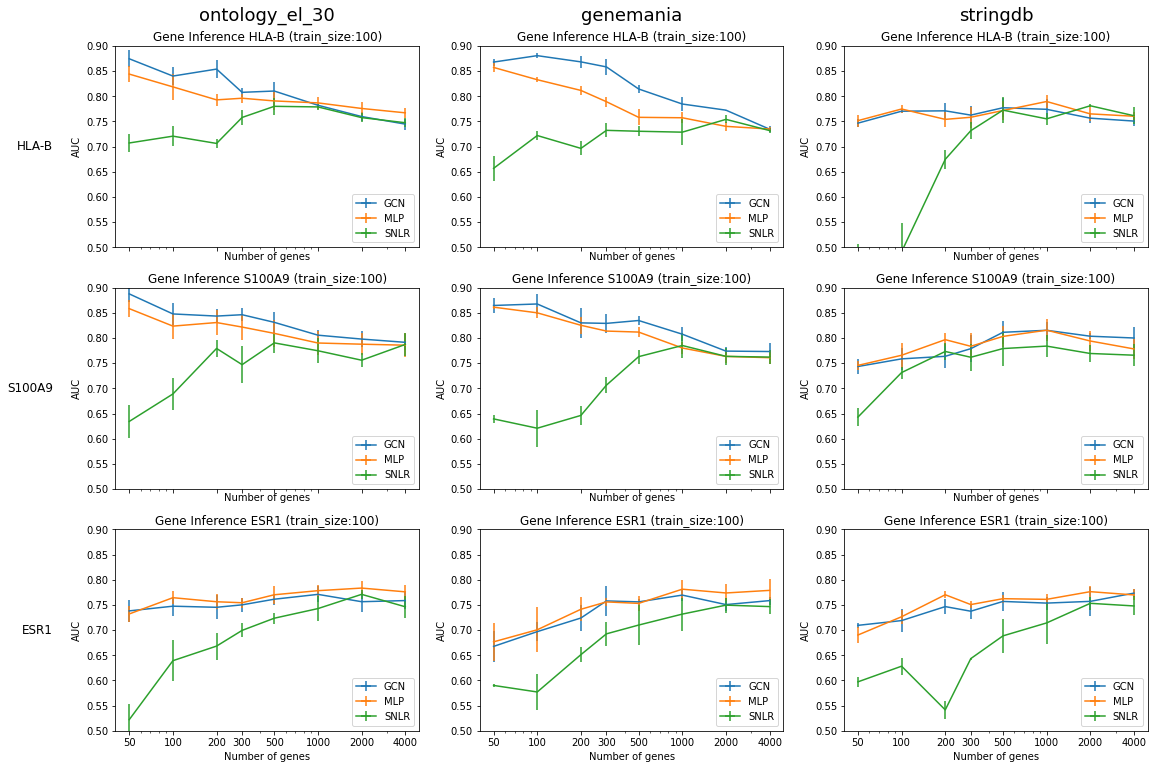

In [40]:
plt.rcParams['figure.figsize'] = (18.5, 12.6)
fig, axs = plt.subplots(3,3, sharex=True, sharey=False)
# fig.suptitle('Sharing both axes')

search_genes = [ "HLA-B", "S100A9", "ESR1",]
for i, plot_gene in enumerate(search_genes):
    for j, graph_name in enumerate([ "ontology_el_30", "genemania", "stringdb"]):

    #     %matplotlib inline
        plot_train_size = 100

        subset = results[(results.train_size==plot_train_size) & 
                          (results.gene==plot_gene) & 
                          (results.num_genes!=400) &      
                          (results.num_genes> 0)  &      
                          (results.graph == graph_name )]

        q = subset.groupby(['model', 'graph', 'num_genes'])['auc']

        todo = [x for x in itertools.product( list(subset["graph"].unique()),list(subset["model"].unique()))]
    #     print(todo)
        linestyles = ['-', '-', '--', '-.', ':']
        for ls, (graph, model) in enumerate(sorted(todo)):
             if 'agg' not in model and  '512_' not in model and  'lay20' not in model and  'lay1' not in model:
                index = list(q.mean()[model, graph].index)
                mean = q.mean()[model,  graph]
                stderr = q.std()[model,  graph]/np.sqrt(q.count()[model, graph])
                displayname = model.replace("CGN","GCN") +"_"+ graph
                displayname = displayname.replace("SLR", "SNLR")
                displayname= displayname.split('_')[0]
                axs[i][j].errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls='-')# if 'ontology' in graph else '--')

#         axs[:,j].set_title(graph_name)
        axs[i][j].set_title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
        axs[i][j].set_ylabel("AUC")
        axs[i][j].set_xlabel("Number of genes")
        axs[i][j].set_xscale("log")
        axs[i][j].set_xticks(sorted(subset["num_genes"].unique()))
        formatter = matplotlib.ticker.ScalarFormatter()
        plt.gca().xaxis.set_major_formatter(formatter)

#         if i == 0:
        axs[i][j].legend(loc='lower right');
            
        axs[i][j].set_ylim(0.5,0.9)
    #     plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5));
    #     fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
    #     print(fd)
    #     if fd > 50:
    #         plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
    #         c = plt.ylim()
    #         plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)

for ax, col in zip(axs[0], [ "ontology_el_30", "genemania", "stringdb"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 25),
                xycoords='axes fraction', textcoords='offset points',
                size=18, ha='center', va='baseline')

for ax, row in zip(axs[:,0], search_genes):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 15, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=12, ha='right', va='center')
    
plt.savefig("../experiments/results/sgi3x3-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')    
plt.show()


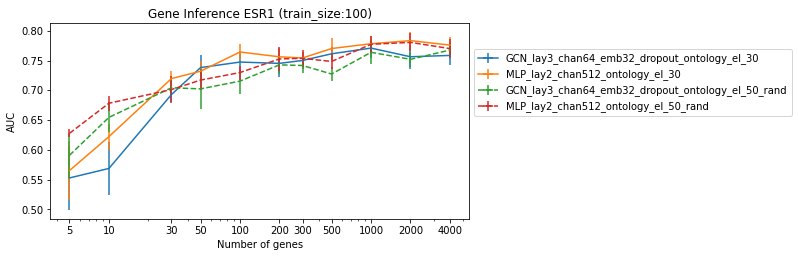

<Figure size 540x259.2 with 0 Axes>

In [21]:
search_genes = ["ESR1"]
for plot_gene in search_genes:

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 100

    subset = results[(results.train_size==plot_train_size) & 
                      (results.gene==plot_gene) & 
                      (results.num_genes!=400) &      
                      (results.num_genes> 0)  &      
                      ((results.graph == "ontology_el_30" ) | (results.graph == "ontology_el_50_rand" ))]

    q = subset.groupby(['model', 'graph', 'num_genes'])['auc']

    todo = [x for x in itertools.product( list(subset["graph"].unique()),list(subset["model"].unique()))]
#     print(todo)
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, (graph, model) in enumerate(sorted(todo)):
         if 'agg' not in model and  '512_' not in model and  'lay20' not in model and 'lay1' not in model and 'SNLR' not in model:
            index = list(q.mean()[model, graph].index)
            mean = q.mean()[model,  graph]
            stderr = q.std()[model,  graph]/np.sqrt(q.count()[model, graph])
            displayname = model.replace("CGN","GCN") +"_"+ graph
            displayname = displayname.replace("SLR", "SNLR")
            plt.errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls='--' if 'rand' in graph else '-')

    plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    plt.ylabel("AUC")
    plt.xlabel("Number of genes")
    plt.xscale("log")
    plt.xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)

    #plt.legend(loc='lower right');
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5));
#     fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
#     print(fd)
#     if fd > 50:
#         plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
#         c = plt.ylim()
#         plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)

    plt.show()
    plt.savefig("../experiments/results/sgi-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')


In [73]:
results2 = pickle.load(open( "../experiments/results/fig-5_ESR1_random1000.pkl", "rb"), encoding='latin1')
results2

,auc,acc,gene,model,graph,num_genes,seed,train_size,time_elapsed
0,0.510315,0.850000,TAS2R8,MLP_lay2_chan512,random_n,10,0,100,2.194260597229004
1,0.500000,0.870000,TAS2R8,MLP_lay2_chan512,random_n,10,1,100,0.4006774425506592
2,0.521810,0.870000,TAS2R8,MLP_lay2_chan512,random_n,10,2,100,0.40882134437561035
3,0.528883,0.863333,TAS2R8,MLP_lay2_chan512,random_n,100,0,100,0.41678547859191895
4,0.500000,0.870000,TAS2R8,MLP_lay2_chan512,random_n,100,1,100,0.4180319309234619
...,...,...,...,...,...,...,...,...,...
1273,0.684981,0.683333,TECPR1,MLP_lay2_chan512,random_n,100,1,100,0.4370906352996826
1274,0.672999,0.676667,TECPR1,MLP_lay2_chan512,random_n,100,2,100,0.4227590560913086
1275,0.706026,0.706667,TECPR1,MLP_lay2_chan512,random_n,1000,0,100,0.4158596992492676
1276,0.703465,0.703333,TECPR1,MLP_lay2_chan512,random_n,1000,1,100,0.40238451957702637
